In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
from pnu_learning import PNULearning
%matplotlib inline

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

Files already downloaded and verified


In [3]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified


In [4]:
testset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [5]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [6]:
x_train, y_train = trainset.data, trainset.targets

In [7]:
x_test, y_test = testset.data, testset.targets

In [8]:
#label = {0, 1}だけのデータで2値分類に
x_train = np.array(x_train).astype(np.float32) / 255.
y_train = np.array(y_train).reshape(-1)
x_train = x_train[y_train<=1]
y_train = y_train[y_train<=1]
y_train = [-1 if y==0 else 1 for y in y_train]
y_train = np.array(y_train).astype(np.int32)
x_test = np.array(x_test).astype(np.float32) / 255.
y_test = np.array(y_test).reshape(-1)
x_test = x_test[y_test<=1]
y_test = y_test[y_test<=1]
y_test = [-1 if y==0 else 1 for y in y_test]
y_test = np.array(y_test).astype(np.int32)

n_train = len(y_train)                  
negative, positive = np.unique(y_train)
n_p = (y_train == positive).sum() 
prior = float(n_p) / float(n_train)

input_shape = x_train.shape[1:]

n_labeled = 100
n_unlabeled = n_train - n_labeled 

n_p_labeled = int(prior * n_labeled)
n_n_labeled = n_labeled - n_p_labeled

np.random.seed(seed=46)
#ランダムに入れ替えて、先頭からn_labeledのデータのみラベルを残す
perm = np.random.permutation(n_train)
x_train = x_train[perm]
y_train = y_train[perm]

x_p_labeled = x_train[y_train == positive][:n_p_labeled]
x_n_labeled = x_train[y_train == negative][:n_n_labeled]

x_p_unlabeled = x_train[y_train == positive][n_p_labeled:]
x_n_unlabeled = x_train[y_train == negative][n_n_labeled:]

x_train = np.concatenate((x_p_labeled, x_n_labeled, x_p_unlabeled, x_n_unlabeled), axis=0)
y_train = np.concatenate((np.ones(n_p_labeled), -np.ones(n_n_labeled), np.zeros(n_unlabeled)), axis=0)

In [9]:
class CNNModel(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.convv1 = nn.Conv2d(3, 96, 3, padding="same")
        self.batchnorm2d1 = nn.BatchNorm2d(96)
        self.convv2 = nn.Conv2d(96, 192, 3, padding="same")
        self.batchnorm2d2 = nn.BatchNorm2d(192)
        self.convv3 = nn.Conv2d(192, 192, 3, padding="same")
        self.batchnorm2d3 = nn.BatchNorm2d(192)
        self.convv4 = nn.Conv2d(192, 10, 1, padding="same")
        self.batchnorm2d4 = nn.BatchNorm2d(10)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(10*input_shape[-1]*input_shape[-1], 512)
        self.batchnorm1d1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 128)
        self.batchnorm1d2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 1)
    
    def forward(self, x):
        #print(x.is_cuda)
        x = self.convv1(x)
        x = self.batchnorm2d1(x)
        x = F.relu(x)
        x = self.convv2(x)
        x = self.batchnorm2d2(x)
        x = F.relu(x)
        x = self.convv3(x)
        x = self.batchnorm2d3(x)
        x = F.relu(x)
        x = self.convv4(x)
        x = self.batchnorm2d4(x)
        x = F.relu(x) 
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.batchnorm1d1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.batchnorm1d2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x
    

In [10]:
model = CNNModel
loss_func = torch.sigmoid
optimizer = optim.Adam
lr = 1e-5
n_epoch = 10
batch_size = 1000
input_shape = [3, 32, 32]
p_ratio = 0.5
eta = 0.2

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
learner = PNULearning(model=model, loss_func=loss_func, optimizer=optimizer, lr=lr, 
                     input_shape=input_shape, p_ratio=p_ratio, eta=eta, device=device)

In [13]:
train_loss_history, train_acc_history, train_precision_history, train_recall_history, \
    test_loss_history, test_acc_history, test_precision_history, test_recall_history = learner.fit(x_train, y_train, x_test, y_test, n_epoch, batch_size, threshold=0, verbose=1)

epoch: 1/10
loss: 0.4804, acc: 0.5682, precision: 0.6894, recall: 0.6875
loss: 0.4776, acc: 0.5788, precision: 0.6596, recall: 0.6583
loss: 0.4833, acc: 0.5591, precision: 0.6197, recall: 0.6813
loss: 0.4791, acc: 0.5745, precision: 0.6158, recall: 0.7450
loss: 0.4777, acc: 0.5788, precision: 0.5798, recall: 0.7319
loss: 0.4780, acc: 0.5854, precision: 0.5786, recall: 0.7702
loss: 0.4854, acc: 0.5622, precision: 0.5479, recall: 0.7365
loss: 0.4823, acc: 0.5604, precision: 0.5315, recall: 0.7102
loss: 0.4766, acc: 0.5710, precision: 0.5384, recall: 0.7392
test_loss: 0.3980, test_acc: 0.5055, test_precision: 0.5028, test_recall: 0.9970
epoch: 2/10
loss: 0.3131, acc: 0.8831, precision: 0.8167, recall: 1.0000
loss: 0.3227, acc: 0.8615, precision: 0.8222, recall: 0.9444
loss: 0.3142, acc: 0.8961, precision: 0.8667, recall: 0.9583
loss: 0.3000, acc: 0.9026, precision: 0.8711, recall: 0.9667
loss: 0.2838, acc: 0.9188, precision: 0.8926, recall: 0.9722
loss: 0.2778, acc: 0.9304, precision: 0.9

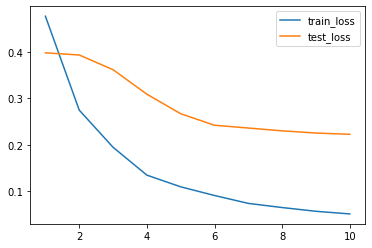

In [14]:
plt.plot([i+1 for i in range(n_epoch)], train_loss_history, label="train_loss")
plt.plot([i+1 for i in range(n_epoch)], test_loss_history, label="test_loss")
plt.legend()
plt.show()

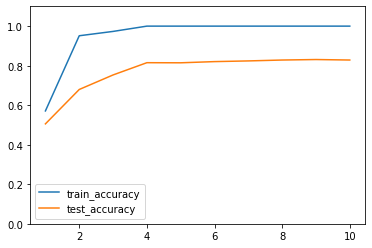

In [15]:
plt.plot([i+1 for i in range(n_epoch)], train_acc_history, label="train_accuracy")
plt.plot([i+1 for i in range(n_epoch)], test_acc_history, label="test_accuracy")
plt.ylim(0, 1.1)
plt.legend()
plt.show()

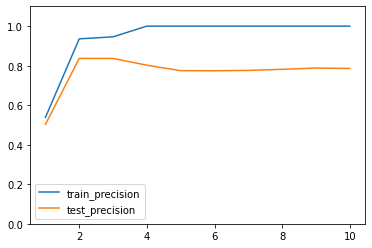

In [16]:
plt.plot([i+1 for i in range(n_epoch)], train_precision_history, label="train_precision")
plt.plot([i+1 for i in range(n_epoch)], test_precision_history, label="test_precision")
plt.ylim(0, 1.1)
plt.legend()
plt.show()

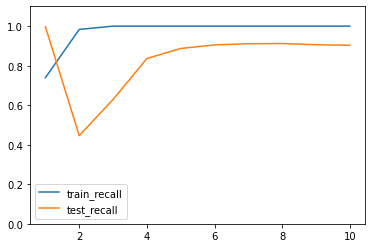

In [17]:
plt.plot([i+1 for i in range(n_epoch)], train_recall_history, label="train_recall")
plt.plot([i+1 for i in range(n_epoch)], test_recall_history, label="test_recall")
plt.ylim(0, 1.1)
plt.legend()
plt.show()